In [ ]:
%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# RNA-seq analysis pipeline with enrichment analysis from Enrichr 
---

By default, we use TCGA data. Users can optionally also upload their own datasets.

In [206]:
import os
import numpy as np
import pandas as pd
import requests
import time
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import math
from collections import OrderedDict
import json
from jupyter_d3 import scatter_plot
from IPython.display import display, IFrame, Markdown, HTML

In [179]:
%%appyter code_exec

{% do SectionField(
    name="DATASET",
    title="Dataset selection",
    subtitle='If using TCGA data, leave both file upload fields blank and simply select the desired cancer type.',
    img = "tcga-logo.png"
) %}


{% do SectionField(
    name='CONFIG',
    title='Analysis parameters',
    img = "cluster-icon.svg"

) %}

{% do SectionField(
    name="ENRICHR_LIBS",
    title="Libraries to include in the Enrichr search",
    img = "enrichr-logo.png"


) %}

{% do SectionField(
    name="L1000FWD",
    title="L1000FWD search parameters",
    img = "l1000fwd.png"
) %}



UsageError: Cell magic `%%appyter` not found.


In [180]:
%%appyter code_exec

data_filename = '''{{ FileField(
    name='data_filename', 
    label='RNA-seq data file (.csv)', 
    description='Upload RNA-seq dataset in csv format. The index of the dataset are genes, the columns are samples.', 
    default='',
    section='DATASET'
) }}'''

clinical_data_filename = '''{{ FileField(
    name='clinical_data_filename', 
    label='Clinical data file (.csv)', 
    description='Upload clinical data in csv format. The first column should contain patient IDs corresponding to those in the RNA-seq file. Each subsequent column is a clinical data field.', 
    default='',
    section='DATASET'
) }}'''

cancer = '''{{ ChoiceField(
        name = "cancer",
        label = "Cancer type",
        description="The value provided as the primary diagnosis on cases in TCGA.",
        choices=["Infiltrating duct carcinoma, NOS","Squamous cell carcinoma, NOS","Lobular carcinoma, NOS","Acute myeloid leukemia, NOS","Hepatocellular carcinoma, NOS","Serous cystadenocarcinoma, NOS","Endometrioid adenocarcinoma, NOS","Adenocarcinoma, NOS","Clear cell adenocarcinoma, NOS","Glioblastoma","Mucinous adenocarcinoma","Transitional cell carcinoma","Malignant melanoma, NOS","Papillary adenocarcinoma, NOS"],
        section="DATASET",
        default="Serous cystadenocarcinoma, NOS" 
) }}'''
    
# Dimensionality reduction parameters

n_pca_components = {{ IntField(
    name='n_pca_components',
    label='Number of PCA components to use for UMAP',
    description='The number of \'top\' PCA components to use for further dimensionality reduction using the UMAP algorithm',
    default=10,
    min=0,
    max=100,
    section='CONFIG',
) }}

n_neighbors = {{ IntField(
    name='n_neighbors',
    label='Number of neighbors for each projected datapoint computed by UMAP',
    description='Smaller values preserve local manifold structure in the dataset as opposed to overall global structure',
    default=40,
    min=2,
    max=200,
    section='CONFIG',
) }}

min_cluster_dist = {{ FloatField(
    name='min_cluster_dist',
    label='Minimum distance between UMAP-projected points',
    description='How tightly packed points produced by dimensionality reduction with UMAP are permitted to be.',
    default=0.3,
    min=0.1,
    max=1,
    section='CONFIG',
) }}


# The number of 'top' genes to use for differential expression
top_n_genes = {{ IntField(
    name='top_n_genes',
    label='Number of Genes',
    description='The number of \'top\' genes to use for differential expression',
    default=250,
    min=100,
    max=1000,
    section='CONFIG',
) }}

# The number of 'top' genes to use for differential expression
heatmap_top_n = {{ IntField(
    name='cluster_top_n',
    label='Number of up and down genes per cluster for heatmap visualizatiton',
    default=100,
    min=100,
    max=1000,
    section='CONFIG',
) }}

# The number of 'top' results to keep from enrichment analysis
top_n_results = {{ IntField(
    name='top_n_results',
    label='Number of Top Enrichment Results',
    description='The number of \'top\' results to keep from enrichment analysis',
    default=5,
    min=1,
    max=100,
    section='CONFIG',
) }}


transcription_libraries = {{MultiChoiceField(name='transcription_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Transcription', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[
                                                    'ARCHS4_TFs_Coexp',
                                                    'ChEA_2016',
                                                    'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
                                                    'ENCODE_Histone_Modifications_2015',
                                                    'ENCODE_TF_ChIP-seq_2015',
                                                    'Epigenomics_Roadmap_HM_ChIP-seq',
                                                    'Enrichr_Submissions_TF-Gene_Coocurrence',
                                                    'Genome_Browser_PWMs',
                                                    'lncHUB_lncRNA_Co-Expression',
                                                    'miRTarBase_2017',
                                                    'TargetScan_microRNA_2017',
                                                    'TF-LOF_Expression_from_GEO',
                                                    'TF_Perturbations_Followed_by_Expression',
                                                    'Transcription_Factor_PPIs',
                                                    'TRANSFAC_and_JASPAR_PWMs',
                                                    'TRRUST_Transcription_Factors_2019'
                                                ])  }}

pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', 
                                         description='Select the Enrichr libraries you would like in your figure.', 
                                         label='Pathways', 
                                         default=[], 
                                         section='ENRICHR_LIBS',
                                         choices=[
                                                    'ARCHS4_Kinases_Coexp',
                                                    'BioCarta_2016',
                                                    'BioPlanet_2019',
                                                    'BioPlex_2017',
                                                    'CORUM',
                                                    'Elsevier_Pathway_Collection',
                                                    'HMS_LINCS_KinomeScan',
                                                    'HumanCyc_2016',
                                                    'huMAP',
                                                    'KEA_2015',
                                                    'KEGG_2019_Human',
                                                    'KEGG_2019_Mouse',
                                                    'Kinase_Perturbations_from_GEO_down',
                                                    'Kinase_Perturbations_from_GEO_up',
                                                    'L1000_Kinase_and_GPCR_Perturbations_down',
                                                    'L1000_Kinase_and_GPCR_Perturbations_up',
                                                    'NCI-Nature_2016',
                                                    'NURSA_Human_Endogenous_Complexome',
                                                    'Panther_2016',
                                                    'Phosphatase_Substrates_from_DEPOD',
                                                    'PPI_Hub_Proteins',
                                                    'Reactome_2016',
                                                    'SILAC_Phosphoproteomics',
                                                    'SubCell_BarCode',
                                                    'Virus-Host_PPI_P-HIPSTer_2020',
                                                    'WikiPathways_2019_Human',
                                                    'WikiPathways_2019_Mouse']) }}

ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Ontologies', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[
                                                'GO_Biological_Process_2018',
                                                'GO_Cellular_Component_2018',
                                                'GO_Molecular_Function_2018',
                                                'Human_Phenotype_Ontology',
                                                'Jensen_COMPARTMENTS',
                                                'Jensen_DISEASES',
                                                'Jensen_TISSUES',
                                                'MGI_Mammalian_Phenotype_Level_4_2019'
                                           ])  }}
    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', 
                                               description='Select the Enrichr libraries you would like in your figure.', 
                                               label='Diseases/Drugs', 
                                               default=[], 
                                               section = 'ENRICHR_LIBS',
                                               choices=[    
                                                    'Achilles_fitness_decrease',
                                                    'Achilles_fitness_increase',
                                                    'ARCHS4_IDG_Coexp',
                                                    'ClinVar_2019',
                                                    'dbGaP',
                                                    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
                                                    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
                                                    'DisGeNET',
                                                    'DrugMatrix',
                                                    'DSigDB',
                                                    'GeneSigDB',
                                                    'GWAS_Catalog_2019',
                                                    'LINCS_L1000_Chem_Pert_down',
                                                    'LINCS_L1000_Chem_Pert_up',
                                                    'LINCS_L1000_Ligand_Perturbations_down',
                                                    'LINCS_L1000_Ligand_Perturbations_up',
                                                    'MSigDB_Computational',
                                                    'MSigDB_Oncogenic_Signatures',
                                                    'Old_CMAP_down',
                                                    'Old_CMAP_up',
                                                    'OMIM_Disease',
                                                    'OMIM_Expanded',
                                                    'PheWeb_2019',
                                                    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_AutoRIF_Gene_Lists',
                                                    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_GeneRIF_Gene_Lists',
                                                    'UK_Biobank_GWAS_v1',
                                                    'Virus_Perturbations_from_GEO_down',
                                                    'Virus_Perturbations_from_GEO_up',
                                                    'VirusMINT']) }}
    
cell_types_libraries = {{ MultiChoiceField(name='cell_types_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Cell Types', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[        
                                                'Allen_Brain_Atlas_down',
                                                'Allen_Brain_Atlas_up',
                                                'ARCHS4_Cell-lines',
                                                'ARCHS4_Tissues',
                                                'Cancer_Cell_Line_Encyclopedia',
                                                'CCLE_Proteomics_2020',
                                                'ESCAPE',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_down',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_up',
                                                'Human_Gene_Atlas',
                                                'Mouse_Gene_Atlas',
                                                'NCI-60_Cancer_Cell_Lines',
                                                'ProteomicsDB_2020',
                                                'Tissue_Protein_Expression_from_Human_Proteome_Map']) }}
    
    
miscellaneous_libraries = {{ MultiChoiceField(name='miscellaneous_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Miscellaneous', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[            
                                                    'Chromosome_Location_hg19',
                                                    'Data_Acquisition_Method_Most_Popular_Genes',
                                                    'Enrichr_Libraries_Most_Popular_Genes',
                                                    'Genes_Associated_with_NIH_Grants',
                                                    'HMDB_Metabolites',
                                                    'HomoloGene',
                                                    'InterPro_Domains_2019',
                                                    'NIH_Funded_PIs_2017_AutoRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_Human_AutoRIF',
                                                    'NIH_Funded_PIs_2017_Human_GeneRIF',
                                                    'Pfam_Domains_2019',
                                                    'Pfam_InterPro_Domains',
                                                    'Table_Mining_of_CRISPR_Studies'])  }}
    
    
legacy_libraries = {{ MultiChoiceField(name='legacy_libraries', 
                                       description='Select the Enrichr libraries you would like in your figure.', 
                                       label='Legacy', 
                                       default=[], 
                                       section = 'ENRICHR_LIBS',
                                       choices=[                
                                            'BioCarta_2013',
                                            'BioCarta_2015',
                                            'ChEA_2013',
                                            'ChEA_2015',
                                            'Chromosome_Location',
                                            'Disease_Signatures_from_GEO_down_2014',
                                            'Disease_Signatures_from_GEO_up_2014',
                                            'Drug_Perturbations_from_GEO_2014',
                                            'ENCODE_Histone_Modifications_2013',
                                            'ENCODE_TF_ChIP-seq_2014',
                                            'GO_Biological_Process_2013',
                                            'GO_Biological_Process_2015',
                                            'GO_Biological_Process_2017',
                                            'GO_Biological_Process_2017b',
                                            'GO_Cellular_Component_2013',
                                            'GO_Cellular_Component_2015',
                                            'GO_Cellular_Component_2017',
                                            'GO_Cellular_Component_2017b',
                                            'GO_Molecular_Function_2013',
                                            'GO_Molecular_Function_2015',
                                            'GO_Molecular_Function_2017',
                                            'GO_Molecular_Function_2017b',
                                            'HumanCyc_2015',
                                            'KEA_2013',
                                            'KEGG_2013',
                                            'KEGG_2015',
                                            'KEGG_2016',
                                            'MGI_Mammalian_Phenotype_2013',
                                            'MGI_Mammalian_Phenotype_2017',
                                            'MGI_Mammalian_Phenotype_Level_3',
                                            'MGI_Mammalian_Phenotype_Level_4',
                                            'NCI-Nature_2015',
                                            'Panther_2015',
                                            'Reactome_2013',
                                            'Reactome_2015',
                                            'TargetScan_microRNA',
                                            'Tissue_Protein_Expression_from_ProteomicsDB',
                                            'WikiPathways_2013',
                                            'WikiPathways_2015',
                                            'WikiPathways_2016']) }}

crowd_libraries = {{ MultiChoiceField(name='crowd_libraries', 
                                      description='Select the Enrichr libraries you would like in your figure.', 
                                      label='Crowd', 
                                      default=[],
                                      section = 'ENRICHR_LIBS',
                                      choices=[                
                                            'Aging_Perturbations_from_GEO_down',
                                            'Aging_Perturbations_from_GEO_up',
                                            'Disease_Perturbations_from_GEO_down',
                                            'Disease_Perturbations_from_GEO_up',
                                            'Drug_Perturbations_from_GEO_down',
                                            'Drug_Perturbations_from_GEO_up',
                                            'Gene_Perturbations_from_GEO_down',
                                            'Gene_Perturbations_from_GEO_up',
                                            'Ligand_Perturbations_from_GEO_down',
                                            'Ligand_Perturbations_from_GEO_up',
                                            'MCF7_Perturbations_from_GEO_down',
                                            'MCF7_Perturbations_from_GEO_up',
                                            'Microbe_Perturbations_from_GEO_down',
                                            'Microbe_Perturbations_from_GEO_up',
                                            'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                                            'SysMyo_Muscle_Gene_Sets']) }}



top_n_drugs = {{IntField(
    name='top_n_drugs',
    label='Number of top drug treatments to suggest for each cluster',
    default=5,
    min=0,
    max=50,
    section='L1000FWD',
) }}
               
enrichr_libraries = OrderedDict([
    ('Diseases/Drugs', diseases_drugs_libraries), 
    ('Ontologies', ontologies_libraries),
    ('Cell Type', cell_types_libraries),
    ('Pathways', pathways_libraries),
    ('Transcription', transcription_libraries),
    ('Legacy', legacy_libraries),
    ('Crowd', crowd_libraries)
])

UsageError: Cell magic `%%appyter` not found.


## Import dataset

If using user-uploaded data, we access those files and set the necessary index names.

Otherwise, we first download the data containing RNA-seq profiles for the selected cancer type from TCGA and the corresponding clinical data for those cases.

The RNA-seq data that is provided has already been processed using the HTSeq Python package, which calculates the number of mapped reads to each gene.

In [181]:
%%appyter hide_code

# Utility function for saving the dataset
def save_data(cancer_type,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs):
    
    # create the root dir
    root_dir = f'./processed_data/{cancer_type}'
    os.makedirs(root_dir, exist_ok=True)

    # /clustering/graphclust/clusters.csv
    #   Barcode,Cluster
    os.makedirs(f'{root_dir}/clustering/graphclust', exist_ok=True)
    df_data_norm_km.to_csv(f'{root_dir}/clustering/graphclust/clusters.csv')
    
    # /pca/10_components/projection.csv
    #   Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
    os.makedirs(f'{root_dir}/pca/{n_pca_components}_components', exist_ok=True)
    df_data_norm_pca.to_csv(f'{root_dir}/pca/{n_pca_components}_components/projection.csv')
    
    # /umap/2_components/projection.csv
    #   Barcode,UMAP-1,UMAP-2
    os.makedirs(f'{root_dir}/umap/2_components', exist_ok=True)
    df_data_norm_umap.to_csv(f'{root_dir}/umap/2_components/projection.csv')
    
     # /diffexp/graphclust/differential_expression.csv
    #   Feature Name,Cluster 2 Log2 fold change,Cluster 0 Log2 fold change,Cluster 1 Log2 fold change,Cluster 3 Log2 fold change,Cluster 2 Adjusted p value,Cluster 0 Adjusted p value,Cluster 1 Adjusted p value,Cluster 3 Adjusted p value,Cluster 2 Mean Counts,Cluster 0 Mean Counts,Cluster 1 Mean Counts,Cluster 3 Mean Counts,Feature Name
    os.makedirs(f'{root_dir}/diffexp/graphclust', exist_ok=True)
    df_diff_expr.to_csv(f'{root_dir}/diffexp/graphclust/differential_expression.csv')
    
    # /cluster_aucs.csv
    #   ,2,0,1,3
    df_aucs.to_csv(f'{root_dir}/cluster_aucs.csv')

UsageError: Cell magic `%%appyter` not found.


In [182]:
# Notebook display util functions

def download_button(content, label, filename):
    # Add download button
    outname = filename.split('.')[0]
    display(HTML('<textarea id="textbox_{outname}" style="display: none;">{content}</textarea> <button style="margin:10px 0;" id="create_{outname}">{label}</button> <a download="{filename}" id="downloadlink_{outname}" style="display: none">Download</a>'.format(**locals())))
    display(HTML('<script type="text/javascript">!function(){{var e=null,t=document.getElementById("create_{outname}"),n=document.getElementById("textbox_{outname}");t.addEventListener("click",function(){{var t,l,c=document.getElementById("downloadlink_{outname}");c.href=(t=n.value,l=new Blob([t],{{type:"text/plain"}}),null!==e&&window.URL.revokeObjectURL(e),e=window.URL.createObjectURL(l)),c.click()}},!1)}}();</script>'.format(**locals())))

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

In [183]:
user_data = False
if (data_filename != "" and clinical_data_filename != ""): user_data = True


In [184]:
data_index = "symbol"
clinical_index = "case_id"

if (user_data):
    df_data = pd.read_csv(data_filename, index_col=0).sort_index()
    df_clinical = pd.read_csv(clinical_data_filename, index_col=0).sort_index()

    df_data.index.name = "symbol"
    df_clinical.index.name = "case_id"
    
    display(df_data.head())
    display(df_clinical.head())
else:
    # Import the RNA-seq and clinical DataFrames with only entries corresponding 
    # the selected cancer type
    aws_url = f'https://tcga-enrichr-viewer.s3.amazonaws.com/{cancer.replace(" ", "%20")}'

    df_data = pd.read_csv(f'{aws_url}_data.csv')
    df_data = df_data.set_index("symbol")

    df_clinical = pd.read_csv(f'{aws_url}_clinical_data.csv')
    df_clinical = df_clinical.set_index("case_id")
    df_clinical = df_clinical.replace("not reported", np.nan)


In [185]:
# Get a list of the clinical features with multiple unique values
features = df_clinical.columns.values

def has_unique_values(feature):
    unique = df_clinical[feature].dropna().unique()
    if len(unique) >= 1: return True
    return False

if (not user_data):
    features = list(filter(
        lambda x: not x in ["primary_diagnosis","submitter_id", "updated_datetime","created_datetime","diagnosis_id", "demographic_id"] 
        and has_unique_values(x), features))

    df_clinical = df_clinical[features]
else:
    features = list(filter(
        lambda x: has_unique_values(x), features))
    df_clinical = df_clinical[features]


    
print(f"{df_clinical.shape[0]} cases, {len(features)} features")

display(df_clinical.head())

764 cases, 31 features


,prior_malignancy,ajcc_pathologic_t,year_of_death,race,synchronous_malignancy,ajcc_staging_system_edition,ethnicity,days_to_death,icd_10_code,ajcc_pathologic_n,...,year_of_diagnosis,ajcc_clinical_n,ajcc_clinical_m,ajcc_clinical_t,ajcc_clinical_stage,age_at_index,gender,days_to_diagnosis,prior_treatment,tumor_stage
case_id,,,,,,,,,,,,,,,,,,,,,
a5b3de4c-f3fa-414c-b809-59c3c1438aa7,no,T1b,NaN,white,No,7th,not hispanic or latino,NaN,C64.1,NX,...,2012.0,NaN,MX,NaN,NaN,63.0,male,0.0,No,stage i
4e244c64-8fb6-4689-a306-3d5ed5c6cca5,no,T1a,NaN,white,No,6th,not hispanic or latino,NaN,C64.1,NX,...,2008.0,N0,M0,T1a,Stage I,58.0,male,0.0,No,stage i
85fcd432-abf4-4bb7-8039-2de41477cb44,no,T3a,NaN,white,No,NaN,NaN,NaN,C64.1,NX,...,2004.0,NX,M0,T2b,Stage II,66.0,female,0.0,No,stage iii
66e2fda4-23de-49c6-bb89-82e9edc56e4b,no,T3a,NaN,white,No,7th,hispanic or latino,NaN,C64.1,N1,...,2010.0,N1,M0,T3a,Stage III,74.0,male,0.0,No,stage iii
78412f82-cc55-43d5-96ca-1d02cf957725,no,T3c,NaN,white,No,7th,not hispanic or latino,NaN,C64.1,N0,...,2012.0,NaN,MX,NaN,Stage III,79.0,male,0.0,No,stage iii


## Process data and compute clusters

Next, we'll need to normalize the RNA-seq data, reduce its dimensionality using PCA and UMAP, and compute clusters of RNA-seq profiles.

In [186]:
# Data size stats

df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "case_id"
display(df_library_size.head()) 

,n_reads,log_n_reads,n_expressed_genes
case_id,,,
55b8d871-dbff-4c4a-8f73-82565588c23f,18238,14.154739,31229788
c573a2f6-2404-4978-8ddc-91af27bab7c6,18084,14.142506,41254059
4edd92e1-5da5-49a3-80e4-fa456aa425b8,17829,14.122019,51576996
8e274b77-c05e-4a8c-a106-c552df1f2d11,17804,14.119995,27106338
f1985735-a188-4567-a88a-530f9b80291b,17715,14.112765,92482667


In [187]:
# Normalization

# take 2500 top most variable rows
df_data_norm = filter_by_var(df_data)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)

In [188]:
display(df_data_norm)

,ea859a83-00c3-40b2-97c1-fb24ad027ea6,10d3a64b-22d0-4846-8972-d78173deca2c,40a9c1d3-6629-4e22-a783-12e0d48349d1,dc5c1a76-30de-4b30-b397-3ad691c92a86,7555e736-a9e2-4b96-a633-fb0f7224d62c,641ba101-135b-4395-9360-2058fabfed56,a3f87411-0a7b-4415-ba17-8edcc2639f6c,04dc8ee3-ec93-4b56-a546-f96746f8122f,c35e4390-2809-4d88-86f3-208de05b338a,817a7f60-2d13-4372-9dcc-740da772740e,...,524a39ee-8fa3-418e-98a2-a6a90e9c8064,0d80fac4-f43e-4a67-b372-0af320966dbc,2dcdf9a1-9437-4515-88c1-1c17d6b6418c,a2e2fac3-cca5-4e33-aa6c-1d9d3ac3aeec,07d409a0-d0dd-415a-95c3-38c26a518c56,8d54a2ed-03f1-4a23-bdd2-f3395f5d3716,dd981e11-4b49-447e-8ebc-d9db4b55ce9b,8a8e05aa-f13a-4142-a335-7aafbee7b664,ef306507-f426-499e-8a1f-3401a522fb6b,a7c1d88a-d3a2-4232-a0df-3bd48fc27cc0
symbol,,,,,,,,,,,,,,,,,,,,,
TG,3.495641,-2.082523,1.997358,1.764606,2.824482,2.606368,3.360814,3.262371,3.465365,-2.511856,...,2.426823,-1.372278,2.670999,1.888303,-0.970849,2.754271,2.116801,2.719076,2.313344,-1.510796
FN1,0.773958,0.403602,2.987698,2.683736,2.233669,2.318375,1.150492,0.359370,0.691781,0.385610,...,2.425759,0.337072,2.302058,2.765096,1.761562,0.802500,2.601543,2.094501,2.866100,0.209160
CTSB,1.816976,1.426741,2.268556,2.316480,2.009784,2.095021,2.265073,1.994137,2.316719,0.867519,...,2.320803,1.345107,1.964187,2.292092,1.799470,1.972316,2.036665,2.080586,2.339932,1.153552
CLU,1.639893,2.440953,2.064827,2.233385,2.227620,1.980662,1.476463,1.464706,1.309157,0.916820,...,2.122088,2.021044,2.284738,2.086597,2.240240,1.580650,1.523843,2.309197,2.094338,1.972272
PGC,-3.006937,-4.193317,-3.613867,-3.760521,-3.510580,-3.686370,-3.753451,-3.309261,-3.352665,-1.525992,...,-3.767412,-2.698221,-3.672521,-3.300316,-3.020328,-3.147311,-3.674039,-3.503458,-3.713218,-3.138268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESRP1,-0.005257,-0.647977,-0.112616,0.062877,0.027649,0.020528,0.009682,0.021525,0.193519,-1.571743,...,0.086624,-0.704510,-0.031205,0.096272,-0.877714,0.217962,0.017808,0.010551,0.080134,-1.363217
HSPA4,0.276409,0.300576,0.349404,0.236721,0.193156,0.397996,0.224185,0.323795,0.310514,0.447620,...,0.295287,0.282788,0.185625,0.212317,0.302023,0.321974,0.466297,0.183719,0.321514,0.197344
NGFR,-0.489513,-1.865803,-0.237030,-0.020896,-0.176812,-0.366119,-1.589686,-0.826646,-1.403238,-1.437564,...,-0.483124,-1.068133,-0.057759,-1.195623,-1.746497,-1.321179,-0.970379,0.355726,-0.589407,-2.370646


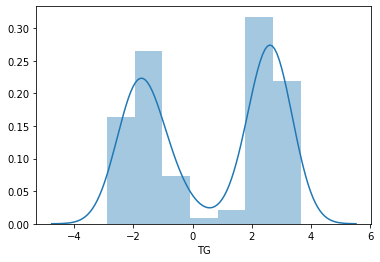

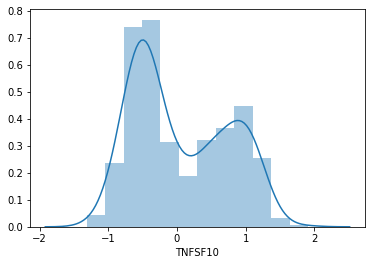

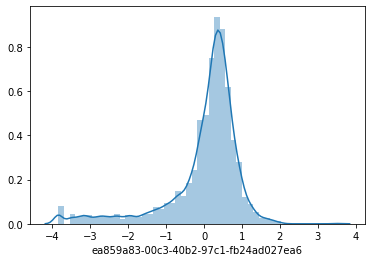

In [189]:
# plot 2 random gene distributions
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
sns.distplot(df_data_norm.iloc[200, :]); plt.show()

# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()

Now let's visualize expression of the most variable genes across the dataset with hierachical clustering and a heatmap.

/Users/nicolemoiseyev/opt/anaconda3/envs/TCGA/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


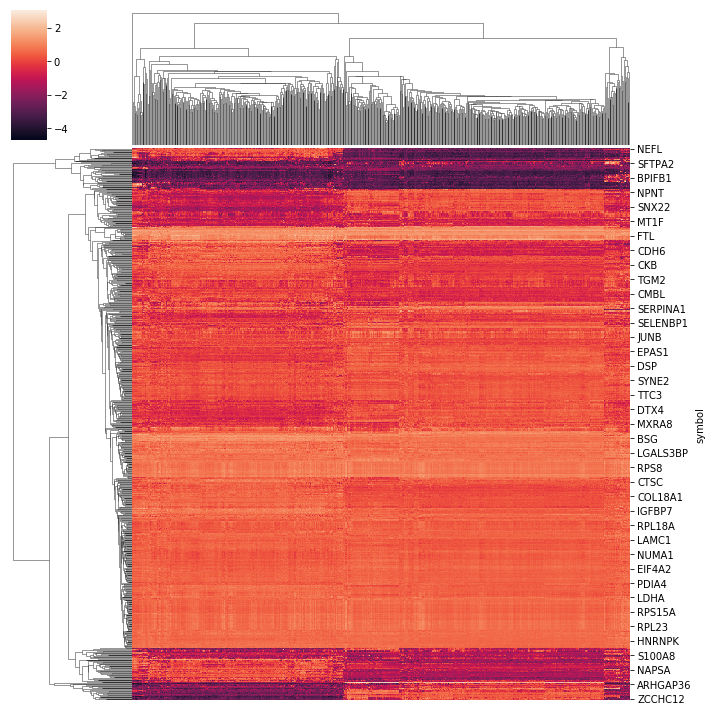

In [190]:
# Normalization
# take top 800 most variable rows

# the "i" in the variable here stands for "initial", since we'll do a different method 
# for selecting genes for a heatmap later
df_data_norm_heatmap_i = filter_by_var(df_data,top_n=800)

# compute log normalization of matrix
df_data_norm_heatmap_i = log2_normalize(df_data_norm_heatmap_i)

# convert to zscores
df_data_norm_heatmap_i = zscore_normalize(df_data_norm_heatmap_i) 

# Plot heatmap
ax = sns.clustermap(df_data_norm_heatmap_i,xticklabels=False)

We use PCA to initially reduce the dimensionality of the dataset before clustering while still maintaining most of the variability.

In [198]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "case_id"

display(df_data_norm_pca.head())
print(df_data_norm_pca.shape[0])

,PCA-0,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,...,PCA-663,PCA-664,PCA-665,PCA-666,PCA-667,PCA-668,PCA-669,PCA-670,PCA-671,PCA-672
case_id,,,,,,,,,,,,,,,,,,,,,
ea859a83-00c3-40b2-97c1-fb24ad027ea6,-14.060915,-10.556412,5.850369,-5.449702,-4.306225,-10.529158,-0.590941,0.584068,-0.070403,1.901384,...,0.015755,0.094268,0.073513,0.002415,-0.073101,0.078456,-0.091381,-0.059280,0.040155,1.965789e-14
10d3a64b-22d0-4846-8972-d78173deca2c,26.463989,0.848270,-2.306361,-2.288578,2.331022,-2.150870,1.754868,-6.261146,0.570700,3.289235,...,0.092591,-0.001091,-0.056086,-0.016403,-0.027797,-0.010018,-0.050839,-0.006212,0.021230,2.001871e-14
40a9c1d3-6629-4e22-a783-12e0d48349d1,-15.359047,7.146301,0.388166,1.897248,3.587840,-5.052247,0.530603,2.348167,-2.470740,1.705687,...,0.004724,0.040000,0.102394,-0.059352,-0.029829,0.038958,0.026629,-0.003821,-0.026933,2.103873e-14
dc5c1a76-30de-4b30-b397-3ad691c92a86,-17.658337,7.044129,-3.404614,2.451678,1.364496,0.371965,2.320854,1.111518,4.139478,1.915517,...,-0.061211,0.036717,0.005027,-0.032797,0.066012,-0.187427,-0.049334,-0.002918,-0.114748,2.088607e-14
7555e736-a9e2-4b96-a633-fb0f7224d62c,-19.754332,-1.387787,-2.210254,1.645311,-2.786396,1.046664,3.624721,1.694139,-3.073531,1.325598,...,-0.028038,-0.083252,-0.018155,0.013491,0.065939,0.001727,-0.114948,-0.067855,-0.022696,2.068484e-14


673


In the two plots below (PCA and UMAP projections), datapoints are color-coded by the selected feature. The size of each point represents the number of reads for that sample.

In [192]:
pca_data = merge(
        df_data_norm_pca[["PCA-0", "PCA-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_pca["PCA-0"])*1.1, max(df_data_norm_pca["PCA-0"])*1.1],
    "y": [min(df_data_norm_pca["PCA-1"])*1.1, max(df_data_norm_pca["PCA-1"])*1.1]
}
    
scatter_plot(pca_data,"PCA-0", "PCA-1",axes,features)

We further reduce the dimensionality of the dataset using the UMAP (Uniform Manifold Approximation and Projection) technique on the data projected onto the first `n_pca_components` PCA components.

In [193]:
# UMAP
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=n_neighbors,
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-0', 'UMAP-1'],
  index=df_data_norm_pca.index,
)

In [194]:
# project data onto its first 2 UMAP components for visualization
umap_data = merge(
        df_data_norm_umap[["UMAP-0", "UMAP-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_umap["UMAP-0"])*1.1, max(df_data_norm_umap["UMAP-0"])*1.1],
    "y": [min(df_data_norm_umap["UMAP-1"])*1.1, max(df_data_norm_umap["UMAP-1"])*1.1]
}

scatter_plot(umap_data,"UMAP-0", "UMAP-1",axes,features)

We continue using the first 2 UMAP components.

To compute clusters, we use the Kmeans method, which requires us to define a total number of clusters. We test a range for the number of total clusters. 

For each number of clusters, we compute silhouette scores, which are a measure of how similar an entry is to its own cluster compared to other clusters. We want to maximize similarity within a cluster and differrences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

In [204]:
def plot_silhouette_analysis(n_clusters, data, cluster_labels, avg_score, sample_values, centers):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [223]:
silhouette_scores = []

max_clusters = math.ceil(df_data_norm_umap.shape[0]**0.5)

for n in range(2, max_clusters):
    X = df_data_norm_umap.values
    clusterer = KMeans(n_clusters=n, random_state=42)
    
    y_pred = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, y_pred, metric='cosine')
    
    # Compute a weighted score that rewards higher numbers of clusters
    weighted_score = silhouette_avg*0.6 + n/max_clusters*0.4
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y_pred)

    silhouette_scores.append({
        "N Clusters": n,
        "Silhouette Score": silhouette_avg,
        "Weighted Score": weighted_score
    })
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Plot the results for this number of clusters
    # plot_silhouette_analysis(n, X, y_pred, silhouette_avg, sample_silhouette_values, centers)


In [243]:
silhouette_scores = pd.DataFrame(silhouette_scores)
display(silhouette_scores.sort_values(["Silhouette Score", "Weighted Score"], ascending=False).reset_index().head())

best_score = silhouette_scores.sort_values('Silhouette Score').iloc[-1].to_dict()
best_weighted = silhouette_scores.sort_values('Weighted Score').iloc[-1].to_dict()

best = {"Silhouette Score": best_score, "Weighted Score": best_weighted}

,index,N Clusters,Silhouette Score,Weighted Score
0,1,3,0.990689,0.640568
1,2,4,0.984987,0.652531
2,0,2,0.953450,0.602839
3,3,5,0.485150,0.368013
4,8,10,0.138976,0.237232


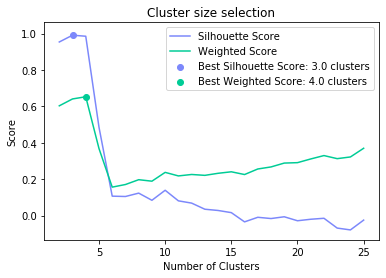

In [244]:
# plot both the uneqeighted and weighted scores as a function of # of clusters
colors = {"Silhouette Score": "#7C88FB", "Weighted Score": "#00CC96"}

for score_type in ['Silhouette Score', 'Weighted Score']:
    plt.plot(silhouette_scores['N Clusters'], silhouette_scores[score_type], label=score_type,color=colors[score_type])
    plt.scatter([best[score_type]['N Clusters']], [best[score_type][score_type]], label=f"Best {score_type}: {best[score_type]['N Clusters']} clusters",color=colors[score_type])
plt.legend()
plt.title('Cluster size selection')
plt.ylabel('Score')
plt.xlabel('Number of Clusters')
plt.show()

In [197]:
# Compute the Kmeans dataframe using the ideal number of clusters
km = KMeans(n_clusters=int(best['Weighted Score']['N Clusters']), random_state=42)
df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km.fit_predict(df_data_norm_umap.values)
]}, index=df_data_norm_umap.index)

print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Computed 3 clusters


Next, we compute differential expression for each cluster. We use the <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> for identifying differentially expressed genes among the different clusters.

In [246]:
# Get differential expression for each cluster
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm.loc[:, df_data_norm.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

display(df_diff_expr.head())

,Cluster 0 CD,Cluster 1 CD,Cluster 2 CD,Symbol
BMP7,-0.112080,0.102470,0.006632,BMP7
NKX2-1,-0.110086,0.140316,-0.029358,NKX2-1
DUOX2,-0.106620,0.083146,0.019269,DUOX2
DUOXA1,-0.091295,0.047995,0.037480,DUOXA1
REG1A,-0.088474,0.046272,0.036539,REG1A


We fit a logistic regression on each clinical feature to see which most accurately predict the cluster each datapoint falls into. We also plot up to 5 ROC curves for features that resulted in an AUC $\gt 0.7$. 

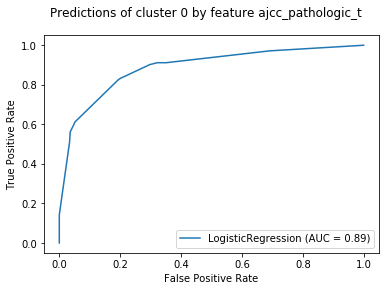

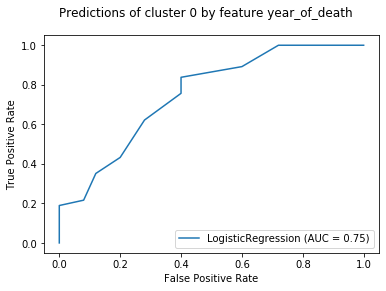

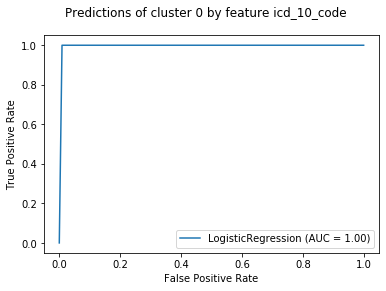

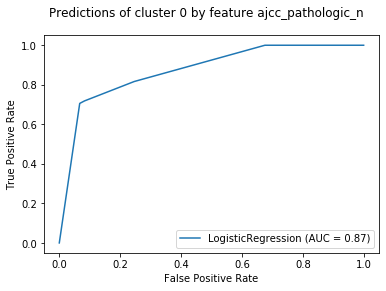

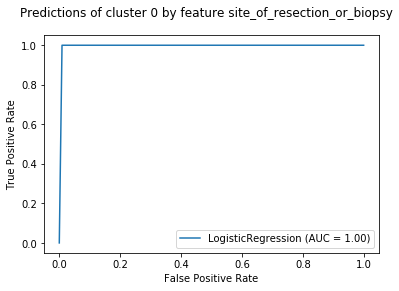

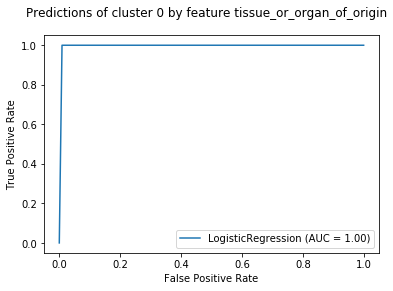

AttributeError: 'DataFrame' object has no attribute 'sort'

In [247]:
# LR
aucs = {}
num_rocs_plotted = 0

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}

    for feature in features:
        lr = LogisticRegression()
        X = df_clinical.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)

        if (len(set(y_true)) < 2): continue # if we only have one class in the dataset
        lr.fit(X, y_true)

        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # plot a few good ROCs, but no more than 5
        if (auc_score > 0.7 and num_rocs_plotted < 6):
            fig = metrics.plot_roc_curve(lr, X, y_true)
            fig.figure_.suptitle(f'Predictions of cluster {cluster} by feature {feature}')
            plt.show()
            num_rocs_plotted += 1

df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Feature"
display(df_cluster_aucs.head())

Next we find the top most up and downregulated genes for each cluster, both to select which data to display in the heatmap below and for Enrichment analysis.

In [248]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_umap, right_on="case_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_pca, right_on="case_id")

In [249]:
# Get top Genes for each cluster
top_genes = {}
all_top_genes = []
heatmap_top_n = min(heatmap_top_n, top_n_genes)
for cluster in df_clustered_umap['Cluster'].unique():
    cd_col = f'Cluster {cluster} CD'
    if cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    all_top_genes.append(up_genes[:heatmap_top_n])
    all_top_genes.append(dn_genes[:heatmap_top_n])
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
all_top_genes = [item for sublist in all_top_genes for item in sublist]  # flatten all genes to one list

NameError: name 'heatmap_top_n' is not defined

We select data corresponding to only the `heatmap_top_n` up and downregulated genes for each cluster. We log-transform and normalize as before, plotting a heatmap for the results.

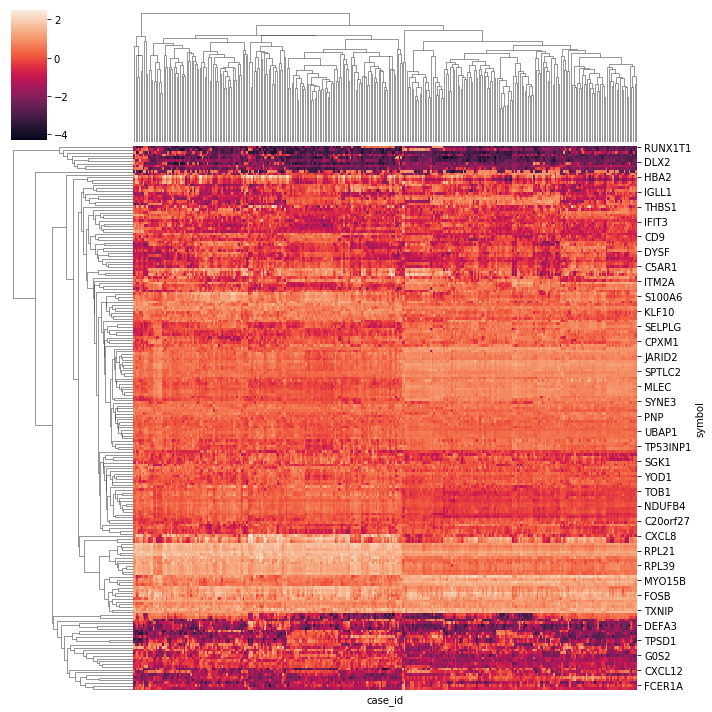

In [174]:
df_data_norm_heatmap_f = df_data.loc[all_top_genes, :]

# compute log normalization of matrix
df_data_norm_heatmap_f = log2_normalize(df_data_norm_heatmap_f)

# convert to zscores
df_data_norm_heatmap_f = zscore_normalize(df_data_norm_heatmap_f) 

# Plot heatmap
ax = sns.clustermap(df_data_norm_heatmap_f,xticklabels=False)

# Enrichr data

We query the Enrichr API for enrichment analysis of the top most upregulated and downregulated genes for each cluster calculated above.

In [134]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

def save_enrichr_data(cancer_type,df_diff_expr,df_clustered_umap,df_all_results,df_cluster_aucs):
    output=f"appyter_data/{cancer_type}"
    os.makedirs(output, exist_ok=True)
    df_diff_expr.to_csv(
        f'{output}/df.tsv',
        sep='\t',
        index=None
    )
    df_clustered_umap.to_csv(
        f'{output}/df_umap.tsv',
        sep='\t',
        index=None
    )
    df_all_results.to_csv(
        f'{output}/df_enrich.tsv',
        sep='\t',
        index=None
    )
    df_cluster_aucs.to_csv(
        f'{output}/cluster_aucs.csv',
        sep='\t',
        index=None
    )

In [135]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        up_link = enrichr_link_from_genes(up_genes, 'cluster %s up' % (cluster))
    else:
        print('cluster %s up: empty' % (cluster))
    if dn_genes.size:
        dn_link = enrichr_link_from_genes(dn_genes, 'cluster %s down' % (cluster))
    else:
        print('cluster %s down: empty' % (cluster))
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_enrichr_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
    for category, libraries in enrichr_libraries.items():
        for library in libraries:
            try:
                results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                results['link'] = link['link']
                results['library'] = library
                results['category'] = category
                results['direction'] = link_type
                results['cluster'] = cluster
                all_enrichr_results.append(results)
            except:
                print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_enrichr_results = pd.concat(all_enrichr_results).reset_index()

In [115]:
# Display a dataframe with clickable enrichr links
df_clickable = df_enrichr_results.copy()
df_clickable['link'] = df_clickable["link"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_enrichr_results.to_csv(), 'Download Enrichr results', 'Enrichr results.csv')

,index,rank,term,pvalue,zscore,combinedscore,overlapping_genes,adjusted_pvalue,,,link,library,category,direction,cluster
0,0,1,ADGRE1 IDG GPCR ARCHS4 coexpression,1.157472e-18,8.026756,331.507370,"[SELPLG, ITGAM, PTAFR, TNFAIP2, AOAH, LSP1, LITAF, TREM1, ADGRG3, HK3, C15ORF39, HLX, RASSF5, ITGAX, PROK2, FLOT2, LGALS9, GBP2, HLA-B, HLA-C, HLA-A, CD4, ATG16L2, SELL, BCL6, EHBP1L1, PLBD1, PLEKHO1, ADAM8, S100A9]",4.074302e-16,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,ARCHS4_IDG_Coexp,Diseases/Drugs,down,2
1,1,2,GPR141 IDG GPCR ARCHS4 coexpression,1.074704e-16,7.491639,275.462439,"[CD84, USP15, ITGAM, PTAFR, TNFAIP2, AOAH, LITAF, LYST, TREM1, ADGRG3, HK3, RGS2, HLX, ITGAX, PROK2, LGALS9, GBP2, HLA-DPA1, NFE2, LYZ, ATG16L2, SELL, RAB37, ELF4, PLBD1, ADAM8, S100A9, S100A8]",1.891478e-14,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,ARCHS4_IDG_Coexp,Diseases/Drugs,down,2
2,2,3,ADGRE3 IDG GPCR ARCHS4 coexpression,9.714882e-16,7.224080,249.719858,"[SELPLG, ITGAM, PTAFR, AOAH, LSP1, LITAF, LYST, TREM1, ADGRG3, HK3, RGS2, C15ORF39, RASSF5, ITGAX, PROK2, FLOT2, HLA-B, HLA-C, HLA-A, IGF2R, SLC25A37, ATG16L2, SELL, BCL6, PLBD1, ADAM8, S100A9]",1.139879e-13,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,ARCHS4_IDG_Coexp,Diseases/Drugs,down,2
3,3,4,FAM26F IDG ionchannel ARCHS4 coexpression,9.714882e-16,7.224080,249.719858,"[FLT3, TNFAIP2, AOAH, LSP1, TNFSF13B, HLA-DMA, FCER1A, CD38, LGALS9, GBP2, GBP4, HLA-DPA1, GBP5, NFE2, SPINK2, SPNS3, RNASET2, HLA-B, HLA-A, PLSCR1, CLEC2B, SELL, RAB37, PSME2, PLEKHO1, SIGLEC1, CPVL]",8.549096e-14,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,ARCHS4_IDG_Coexp,Diseases/Drugs,down,2
4,4,5,ADGRE2 IDG GPCR ARCHS4 coexpression,6.944611e-14,6.688963,202.663715,"[ITGAM, PTAFR, TNFAIP2, AOAH, LSP1, LITAF, TREM1, ADGRG3, HK3, HLX, RASSF5, ITGAX, PROK2, LGALS9, GBP2, RNASET2, HLA-B, HLA-C, CD4, ATG16L2, SELL, BCL6, EHBP1L1, PLBD1, ADAM8]",4.889006e-12,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,ARCHS4_IDG_Coexp,Diseases/Drugs,down,2
5,0,1,"Bed nuclei of the stria terminalis, anterior division, anteromedial area",2.783908e-05,3.720930,39.029097,"[RNASET2, PTAFR, FHL1, NLRC5, CLU, PARP8, HOXA10, SOCS3, RGS2, S100A6, IGF2BP1, MSRB3, DBN1, ITM2C]",6.102326e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,Allen_Brain_Atlas_up,Cell Type,down,2
6,1,2,A4 noradrenergic cell group,1.136955e-04,3.455150,31.379623,"[LGALS3BP, KDM5D, RNASET2, CTSZ, SLC2A1, LSP1, SLC5A3, LTBP1, CD9, HMOX1, CTSC, S100A8, TNS1]",1.246102e-01,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,Allen_Brain_Atlas_up,Cell Type,down,2
7,2,3,caudate nucleus,1.136955e-04,3.455150,31.379623,"[TOP2A, PPP1R16B, LGALS3BP, SLC44A1, ACTN1, RNASET2, LMO2, MN1, CD4, RGS2, DACH1, PRKAR2B, CD9]",8.307350e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,Allen_Brain_Atlas_up,Cell Type,down,2
8,3,4,mantle zone of PO2,1.136955e-04,3.455150,31.379623,"[SERPINA1, SH3KBP1, RHBDD2, FHL1, MLC1, EPX, CLU, PARP8, HOXA10, SELL, RBBP6, BUB3, VAT1L]",6.230512e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,Allen_Brain_Atlas_up,Cell Type,down,2
9,4,5,periventricular stratum of Str,1.136955e-04,3.455150,31.379623,"[TOP2A, PPP1R16B, LGALS3BP, SLC44A1, ACTN1, RNASET2, LMO2, MN1, CD4, RGS2, DACH1, PRKAR2B, CD9]",4.984410e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=dd6275db75f1efe3d6222df3d8f6f975,Allen_Brain_Atlas_up,Cell Type,down,2


## L1000 Data

We query the <a href="https://amp.pharm.mssm.edu/L1000FWD/" target="_blank">L1000 Fireworks Display</a> (L1000FWD) API to find the most similar and most dissimilar RNA-seq signatures from the L1000 database for each cluster based on the up and down genes. We also display the interactive projection of those results for each cluster as provided by L1000FWD.

In [116]:
# Util functions
def l1000fwd_results_from_genes(up_genes, down_genes, description='', l100fwd_link='http://amp.pharm.mssm.edu/L1000FWD/'):
    ''' Functional access to L1000FWD API
    '''
    import time
    time.sleep(1)
    response = requests.post(l100fwd_link + 'sig_search', json={
    'up_genes': list(up_genes),
    'down_genes': list(down_genes),
    })
    l1000fwd_results =  {}
    if response.status_code != 200:
        raise Exception('L1000FWD failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    if 'KeyError' in response.text:
        l1000fwd_results['result_url'] = None
    else:
        # Get ID and URL
        result_id = response.json()['result_id']
        l1000fwd_results['result_url'] = 'https://amp.pharm.mssm.edu/l1000fwd/vanilla/result/'+result_id
        l1000fwd_results['result_id'] = result_id

        # Get Top
        l1000fwd_results['signatures'] = requests.get(l100fwd_link + 'result/topn/' + result_id).json()

    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    return l1000fwd_results

def l1000fwd_sig_link(sig_id):
    return 'https://amp.pharm.mssm.edu/dmoa/sig/' + sig_id

def get_signature_by_id(sig_id):
    response = requests.get("http://amp.pharm.mssm.edu/L1000FWD/sig/" + sig_id)
    if response.status_code != 200:
        raise Exception('L1000FWD signature query  failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    return response.json()

In [ ]:
def plot_l1000fwd_results(l1000fwd_results, plot_counter,cluster_id,nr_drugs=7, height=300):
    # Check if results
    if l1000fwd_results['result_url']:

        # Display cluster title
        display(HTML('<h1>Cluster {}</h1>'.format(cluster_id)))

        # Display IFrame
        display(IFrame(l1000fwd_results['result_url'], width="1000", height="1000"))
    
        # Display tables
        for direction, signature_list in l1000fwd_results['signatures'].items():

            # Fix dataframe
            rename_dict = {'sig_id': 'Signature ID', 'pvals': 'P-value', 'qvals': 'FDR', 'zscores': 'Z-score', 'combined_scores': 'Combined Score'}
            signature_dataframe = pd.DataFrame(signature_list)[list(rename_dict.keys())].rename(columns=rename_dict).sort_values('P-value').rename_axis('Rank')
            signature_dataframe.index = [x + 1 for x in range(len(signature_dataframe.index))]
            signature_csv = signature_dataframe.to_csv(sep=",")

            # Display table
            pd.set_option('max.colwidth', None)
            signature_dataframe['Signature ID'] = [f'<a href={l1000fwd_sig_link(x)} target="_blank">{x}</a>' for x in signature_dataframe['Signature ID']]
            table_html = signature_dataframe.to_html(escape=False, classes='w-100')
            display(HTML(f'<h2>{direction.title()} Signatures: </h2>'))
            display(HTML(f'<style>.w-100{{width: 100% !important;}}</style><div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))

            # Display download button
            download_button(signature_csv, f'Download {direction.title()} Signatures', f'Cluster {cluster_id} L1000FWD {direction.title()} signatures.csv')
        # Link
        display(HTML('Full results available at: <a href="{result_url}" target="_blank">{result_url}</a>.'.format(**l1000fwd_results)))

    # Display error
    else:
        display(Markdown('### No results were found.\n This is likely due to the fact that the gene identifiers were not recognized by L1000FWD. Please note that L1000FWD currently only supports HGNC gene symbols (https://www.genenames.org/). If your dataset uses other gene identifier systems, such as Ensembl IDs or Entrez IDs, consider converting them to HGNC. Automated gene identifier conversion is currently under development.'))


In [ ]:
plot_counter = 0
all_l1000fwd_results = {}
for cluster, (up_genes, dn_genes) in top_genes.items():
    results = l1000fwd_results_from_genes(up_genes,dn_genes)
    all_l1000fwd_results[cluster] = results
    plot_l1000fwd_results(results,plot_counter,cluster)
    plot_counter += 1

Based on the signatures most "opposite" to the profile of a given cluster (i.e. up and down genes are reversed), we can obtain a set of drugs that may "perturb" that cluster into the healthy direction by upregulating its downregulated genes and downregulating the upregulated genes. These may present effective treatments for patients belonging to that cluster.

In [ ]:
df_drugs = pd.read_csv("https://amp.pharm.mssm.edu/l1000fwd/download/Drugs_metadata.csv")

# Load top drug suggestions for each cluster based on the drugs used to produce the top_n_drugs opposite signatures
drug_results = {}
for cluster, results in all_l1000fwd_results.items():
    opposite_sigs = results["signatures"]["opposite"][:top_n_drugs]
    sig_ids = [sig["sig_id"] for sig in opposite_sigs]
    pert_ids = []
    for sig_id in sig_ids:
        signature = get_signature_by_id(sig_id)
        pert_ids.append(signature["pert_id"])
    
    df_cluster_drugs = df_drugs[df_drugs["pert_id"].isin(pert_ids)].copy()
    df_cluster_drugs["cluster"] = cluster
    df_cluster_drugs = df_cluster_drugs[["cluster", *list(filter(lambda x: x!="cluster", df_cluster_drugs.columns))]]
    drug_results[cluster] = df_cluster_drugs
    
df_all_drugs = pd.concat(drug_results).reset_index()

In [ ]:
# Display a dataframe with clickable enrichr links
df_clickable = df_all_drugs.copy()
df_clickable['pert_url'] = df_clickable["pert_url"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_all_drugs.to_csv(), 'Download L1000FWD drug results', 'L1000FWD drugs.csv')

In [177]:
data_filename = ''''''''
clinical_data_filename = ''''''''
cancer = '''Papillary adenocarcinoma, NOS'''
# Dimensionality reduction parameters
n_pca_components = 10
n_neighbors = 40
min_cluster_dist = 0.3
# The number of 'top' genes to use for differential expression
top_n_genes = 250
# The number of 'top' genes to use for differential expression
cluster_top_n = 100
# The number of 'top' results to keep from enrichment analysis
top_n_results = 5
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
cell_types_libraries = []
miscellaneous_libraries = []
legacy_libraries = []
crowd_libraries = ['Disease_Perturbations_from_GEO_down']
top_n_drugs = 5
enrichr_libraries = OrderedDict([
    ('Diseases/Drugs', diseases_drugs_libraries), 
    ('Ontologies', ontologies_libraries),
    ('Cell Type', cell_types_libraries),
    ('Pathways', pathways_libraries),
    ('Transcription', transcription_libraries),
    ('Legacy', legacy_libraries),
    ('Crowd', crowd_libraries)
])